In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline

In [2]:
mpl.style.use('ggplot')
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'xtick.labelsize': 'x-large'})
mpl.rcParams.update({'xtick.major.size': '0'})
mpl.rcParams.update({'ytick.labelsize': 'x-large'})
mpl.rcParams.update({'ytick.major.size': '0'})

In [3]:
# https://stackoverflow.com/questions/18386210/annotating-ranges-of-data-in-matplotlib
def draw_brace(ax, xspan, yoffset, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2+1)]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yoffset + (.05*y - .02)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yoffset+.07*yspan, text, ha='center', va='bottom', fontdict={'family': 'monospace'})

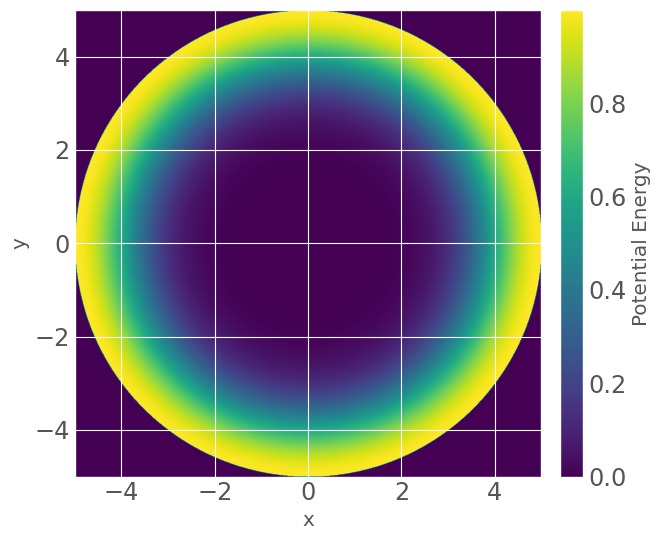

In [23]:
def wall_potential(x, y, sphere_radius=5.0):
    r = sphere_radius - np.sqrt(x ** 2 + y ** 2)

    def gauss_potential(r, epsilon=1.0, sigma=1.0):
        arg = -0.5 * ((r / sigma) ** 2)
        return epsilon * np.exp(arg)
    
    return np.where(r >= 0, gauss_potential(r), 0)

spacing = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(spacing, spacing)

fig = plt.Figure(figsize=(10, 6.18), dpi=100)
ax = fig.add_subplot()
img = ax.imshow(wall_potential(x, y).reshape((-1, 1000)), extent=[-5, 5, -5, 5])
ax.set_xlabel('x')
ax.set_ylabel('y')
divider = make_axes_locatable(ax)
cb = fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.05, pad=-0.3)
cb.set_label("Potential Energy")
fig

In [24]:
fig.savefig('../md-wall-potential.svg', bbox_inches='tight', facecolor=(1, 1, 1, 0))

In [34]:
def lj_wall_energy(r, r_extrap, r_cut, sigma=1.0, epsilon=1.0):
    def lj(r):
        a = (sigma / r) ** 6
        return 4 * epsilon * (a ** 2 - a)
    
    def lj_force(r):
        lj1 = 4 * epsilon * (sigma ** 12)
        lj2 = 4 * epsilon * (sigma ** 6)
        r2_inv = 1 / (r * r)
        r6_inv = r2_inv * r2_inv * r2_inv
        return r2_inv * r6_inv * (12.0 * lj1 * r6_inv - 6.0 * lj2)
    
    if r_extrap == 0:
        return lj(r)
    
    v_extrap = lj(r_extrap)
    f_extrap = lj_force(r_extrap)
    
    return np.where(r <= r_extrap, v_extrap + (r_extrap - r) * f_extrap, lj(r))

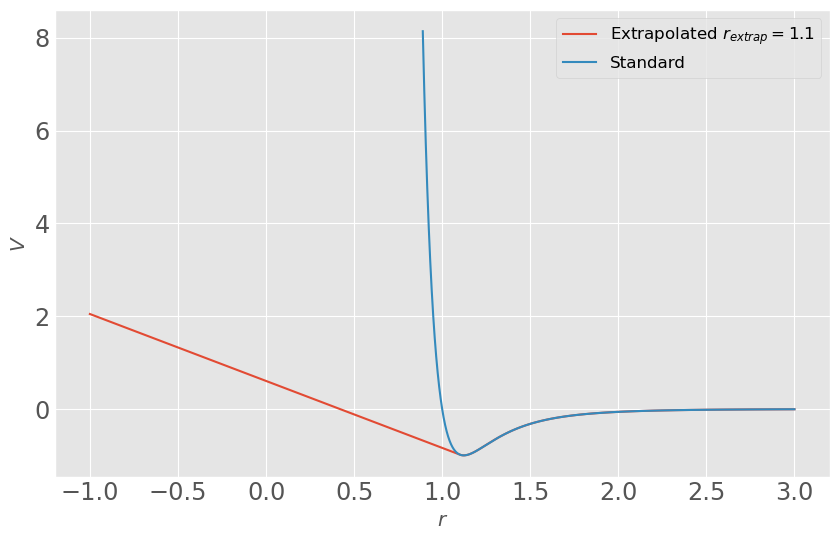

In [44]:
r = np.linspace(-1, 3, 1000)
r_without = np.linspace(0.89, 3, 1000)

energy = lj_wall_energy(r, 1.1, 3.0)
energy_base = lj_wall_energy(r_without, 0.0, 3.0)

fig = plt.Figure(figsize=(10, 6.18), dpi=100)
ax = fig.add_subplot()

ax.plot(r, energy, label=r"Extrapolated $r_{extrap} = 1.1$")
ax.plot(r_without, energy_base, label="Standard")
ax.set_xlabel("$r$")
ax.set_ylabel("$V$")
ax.legend()
fig

In [45]:
fig.savefig('../md-wall-extrapolate.svg', bbox_inches='tight', facecolor=(1, 1, 1, 0))